<a href="https://colab.research.google.com/github/DaniAffCH/BeSTreet/blob/master/StreetTrack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import pandas as pd
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import time 
import datetime
import re

**Preprocessing**

In [44]:
def OneHotToDf(df, field):
  onehot_encoder = OneHotEncoder(sparse=False)
  arr = np.array(df[field])
  arrReshaped = arr.reshape(len(arr), 1)
  field_OH = onehot_encoder.fit_transform(arrReshaped)

  new_columns=list()
  for col, values in zip(df[field], onehot_encoder.categories_):
    new_columns.extend([field + '_' + str(value) for value in values])

  new_df= pd.concat([df, pd.DataFrame(field_OH, columns=new_columns)], axis='columns')
  del new_df[field]

  return new_df

def fromDataToGoniometric(date):
  minutiSettimana = 7*24*60
  data = re.search("(\d{2})/(\d{2})/(\d{4}) (\d{2}):(\d{2})", date)
  unix_timestamp = datetime.datetime(int(data.group(3)),int(data.group(2)),int(data.group(1)),int(data.group(4)),int(data.group(5))).timestamp()
  myTimestamp = unix_timestamp - (24 * 4 * 60 * 60)
  myTimestamp /= 60
  return [np.sin( 2 * np.pi * myTimestamp / minutiSettimana ), np.cos( 2 * np.pi * myTimestamp / minutiSettimana )]

   Tempo  StradaID_0  StradaID_1  StradaID_2  sin_periodo  cos_periodo
0    609         1.0         0.0         0.0    -0.276836    -0.960917
1    412         0.0         1.0         0.0    -0.483719    -0.875223
2    471         0.0         1.0         0.0    -0.167506     0.985871
3    600         0.0         0.0         1.0     0.578671    -0.815561
4    437         0.0         1.0         0.0     0.399892    -0.916562
            Tempo  StradaID_0  StradaID_1  StradaID_2  sin_periodo  cos_periodo
count    5.000000    5.000000    5.000000    5.000000     5.000000     5.000000
mean   505.800000    0.200000    0.600000    0.200000     0.010101    -0.516479
std     92.556469    0.447214    0.547723    0.447214     0.456329     0.841545
min    412.000000    0.000000    0.000000    0.000000    -0.483719    -0.960917
25%    437.000000    0.000000    0.000000    0.000000    -0.276836    -0.916562
50%    471.000000    0.000000    1.000000    0.000000    -0.167506    -0.875223
75%    600.000

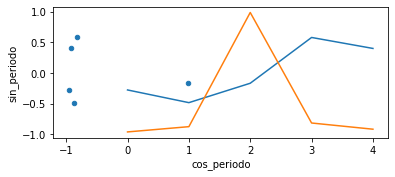

In [45]:
df = pd.read_csv("/content/streetData.csv")

df = OneHotToDf(df, "StradaID")

# Encoding tempo come combinazione di seno/coseno (periodicità)

newCol = list()

for row in df["Data"]:
  newCol.append(fromDataToGoniometric(row))

df= pd.concat([df, pd.DataFrame(newCol, columns=["sin_periodo", "cos_periodo"])], axis='columns')
del df["Data"]

print(df.head())
print(df.describe())

df.plot.scatter('cos_periodo','sin_periodo').set_aspect('equal');

df.sin_periodo.plot()
df.cos_periodo.plot()

feature = ["StradaID_0", "StradaID_1", "StradaID_2", "sin_periodo", "cos_periodo"]
label = "Tempo"

**Modello**

In [46]:
def buildModel(my_learning_rate):
  model = keras.models.Sequential()
  layer = keras.layers.Dense(units=1)
  model.add(layer)
  model.compile(optimizer=keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[keras.metrics.RootMeanSquaredError()])
  return model

def fitModel(model, df, feature, label, batch_size, epochs):
  history = model.fit(x=df[feature],
                      y=df[label],
                      batch_size=batch_size,
                      epochs=epochs)

  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  epochs = history.epoch
  
  hist = pd.DataFrame(history.history)
 
  rmse = hist["root_mean_squared_error"]

  return trained_weight, trained_bias, epochs, rmse

lr = 0.8
batch = 1
epochs = 200
model = buildModel(lr)
# Side effect su model??
tr_weight, tr_bias, epochs, rmse = fitModel(model, df, feature, label, batch, epochs)

Epoch 1/200

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

5/5 [==============================] - 0s 1ms/step - loss: 256075.9062 - root_mean_squared_error: 506.0394
Epoch 2/200
5/5 [==============================] - 0s 1ms/step - loss: 243274.1562 - root_mean_squared_error: 493.2283
Epoch 3/200
5/5 [==============================] - 0s 1ms/step - loss: 234272.3281 - root_mean_squared_error: 484.0169
Epoch 4/200
5/5 [==============================] - 0s 2ms/step - loss: 226321.1562 - root_mean_squared_error: 475.7322
Epoch 5/200
5/5 [===============

**Errore e predict**

In [47]:
def plot_the_loss_curve(epochs, rmse):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()  


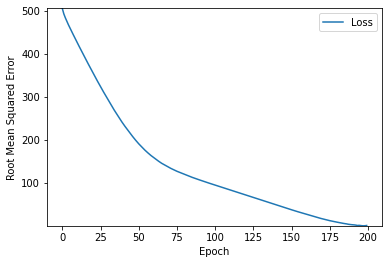

In [48]:
plot_the_loss_curve(epochs, rmse)

In [57]:
street = {
    0:"Verità-Porta Romana-Cassia",
    1:"Ipercoop-Ponte Sodo",
    2:"Centro-Ponte Sodo"
}
min = 99999
date = input("Data: ")
for c in range(3):
  data = [[0, 0, 0]+fromDataToGoniometric(date)]
  data[0][c] = 1
  print("DATA PER IL PREDICT: ")
  predict = model.predict(data)[0][0]
  predictFormatted = str(datetime.timedelta(seconds=int(predict)))[-5:]
  print(data[0])
  print(street[c]+", tempo stimato: "+predictFormatted+"\n")

Data: 22/10/2020 01:30
DATA PER IL PREDICT: 
[1, 0, 0, 0.3826834323653043, -0.9238795325111979]
Verità-Porta Romana-Cassia, tempo stimato: 10:27

DATA PER IL PREDICT: 
[0, 1, 0, 0.3826834323653043, -0.9238795325111979]
Ipercoop-Ponte Sodo, tempo stimato: 07:14

DATA PER IL PREDICT: 
[0, 0, 1, 0.3826834323653043, -0.9238795325111979]
Centro-Ponte Sodo, tempo stimato: 09:49

